# 이전 게시물

[1편. 이상탐지 너 뭐야?](https://dacon.io/codeshare/4758)  
[2편. 신용카드 사기 탐지(1부)](https://dacon.io/codeshare/4833)  
[3편. 신용카드 사기 탐지(2부)](https://dacon.io/codeshare/4853)  
[4편. 비지도 학습 기반의 머신러닝 기법(1부)](https://dacon.io/codeshare/4874)  
[5편. 비지도 학습 기반의 머신러닝 기법(2부)](https://dacon.io/codeshare/4890)

## **CONTENTS**

#### **1. 신용카드 사기 탐지**

#### **2. 일반 PCA를 활용한 이상치 탐지**
 
- 원본 차원의 수와 동일한 PCA 주성분 수 
- 최적의 주성분 개수 찾기

#### **3. 희소 PCA를 활용한 이상치 탐지**

#### **4. 커널 PCA를 활용한 이상치 탐지**

#### **5. GRP를 활용한 이상치 탐지**

### **1.신용카드 사기 탐지**

오늘은 신용카드 거래 데이터를 이용하여 사기 거래 탐지 모델을 만들어 보려고 합니다.  
먼저, 신용카드 거래 데이터를 불러오고, 이상치 평가 함수와 관련 시각화 함수들을 만들어보겠습니다.

In [1]:
# 라이브러리를 불러옵니다.
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


신용 카드 거래 데이터를 불러옵니다.

In [3]:
current_path = os.getcwd()
file = os.path.sep.join(['/drive/MyDrive/데이콘_이상탐지', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

데이터의 형태는 아래와 같습니다.

In [4]:
# Preview data
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Describe data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


총 사기 거래 데이터의 수는 492개 입니다.

In [6]:
# Count total fraud
print("Number of fraudulent transactions:", data['Class'].sum())

Number of fraudulent transactions: 492


test 데이터는 33% 비율로 설정하여 train과 test 데이터 셋을 분리합니다.

In [7]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

# Split to train and test and scale features
dataX = data.drop(['Class'],axis=1)
dataY = data.loc[:,'Class'].copy()

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)
    
featuresToScale = X_train.columns
sX = pp.StandardScaler(copy=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

이상치 평가 함수과 시각화 함수를 생성합니다.

In [8]:
# Calculate reconstruction error
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [9]:
# Plot results
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [10]:
# View scatterplot
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

### **2.일반 PCA를 활용한 이상치 탐지**

#### **원본 차원의 수와 동일한 PCA 주성분 수**

PCA 기법을 사용할 때, 주성분의 수를 설정하는 것이 중요합니다.  
만약, 주성분의 수가 원본 차원의 수와 동일하다면 PCA 기법을 이용하여 주성분을 생성할 때, 데이터의 분산/정보를 100% 추출하게 됩니다.  
즉, 사기 거래와 일반 정상 거래를 재구성 시, 오차가 적어 둘을 정확히 분리하기 어렵게 되죠.  
실습을 통해서 원본 차원의 수와 PCA 주성분 수가 같은 경우 이상치 탐지 모델이 잘 작동하는지 확인해 보도록 하겠습니다.

신용카드 거래 데이터의 원본 피처의 수는 30개 입니다.  
이와 동일한 개수의 주성분 수를 가지는 경우는 아래와 같습니다.  
30개의 주성분을 생성한 후, inverse 함수를 이용하여 주성분으로부터 원본 거래 데이터를 재구성합니다.

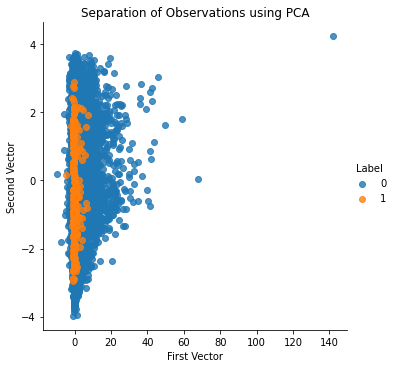

In [28]:
from sklearn.decomposition import PCA
# 원본 피처의 수 = 주성분 수 = 30개
n_components = 30
whiten = False
random_state = 2018

# 주성분 생성
pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

#inverse 함수를 이용하여 주성분으로부터 원본 거래 데이터 재구성
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

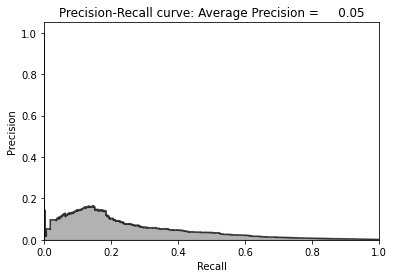

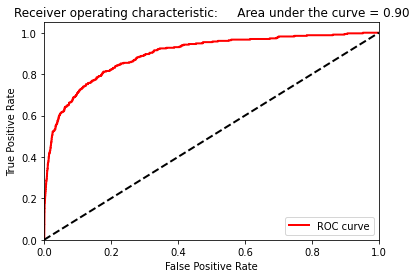

In [12]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [13]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.15
Recall:  0.15
Fraud Caught out of 330 Cases: 51


위의 결과를 확인해보면 평균 정밀도가 0.14로 사용 불가한 사기 탐지 솔루션인 것을 알 수 있습니다.

#### **최적의 주성분 개수 찾기**

이번에는 최적의 주성분 개수를 찾아 이상치 탐지 모델을 만들어 보겠습니다.

여러 실험을 진행한 결과,  27개의 주성분을 사용하여 PCA를 진행한 경우가 가장 높은 정밀도를 보이는 것을 확인할 수 있었습니다.

27개의 주성분을 이용한 모델을 생성하면 아래와 같습니다.

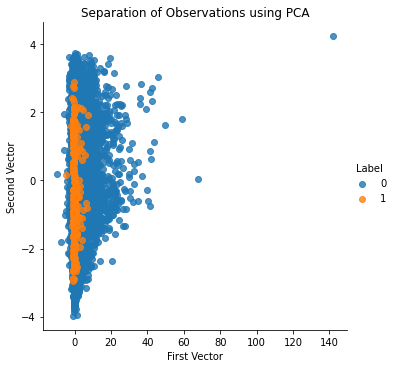

In [14]:
from sklearn.decomposition import PCA
# 27개 주성분을 이용하여 PCA 진행
n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

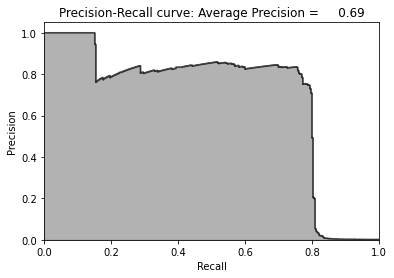

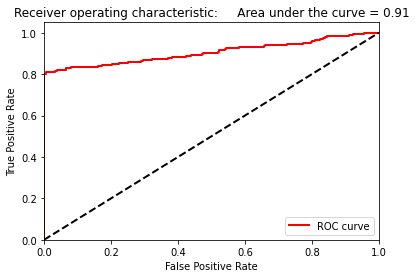

In [15]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [16]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.75
Recall:  0.79
Fraud Caught out of 330 Cases: 261


위의 결과를 확인해보면 평균 정밀도가 0.75이고 사기 거래의 80%를 탐지할 수 있는 사기 탐지 솔루션이 생성된 것을 확인할 수 있습니다.

### 3.희소 PCA를 활용한 이상치 탐지

다음으로 희소 PCA를 활용하여 이상치 탐지를 진행하도록 하겠습니다.

희소 PCA는 일반 PCA와 유사하지만 일반 PCA 보다 밀도가 낮은 버전을 제공한다는 특징이 있습니다.

또한, 일반 PCA는 주성분이 일반적으로 모든 입력 변수의 선형 조합이라는 단점이 있는 반면, 희소 PCA는 몇 개의 입력 변수만 포함하는 선형 조합을 찾는다는 장점을 가지고 있습니다.

그리고 희소 수준을 제어하는 알파 파라미터 설정이 필요하며 알파 파라미터 값이 클수록 더 희소한 주성분을 생성합니다.

동일한 데이터를 이용하여 주성분 개수가 27개인 이상치 탐지 모델을 생성하겠습니다.

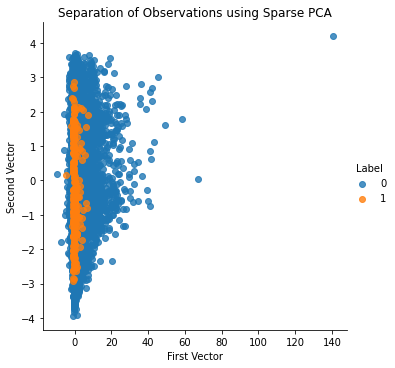

In [17]:
# 희소 PCA
from sklearn.decomposition import SparsePCA

n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, \
                alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

희소 PCA의 경우, 원본 차원으로 변환해주는 함수가 따로 없어 연산을 통해 직접 원본 차원으로 재생성해야 합니다.


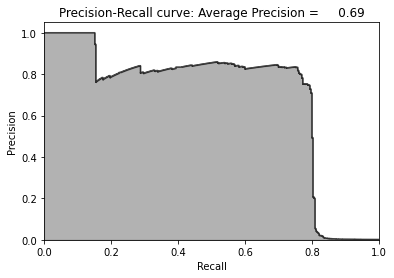

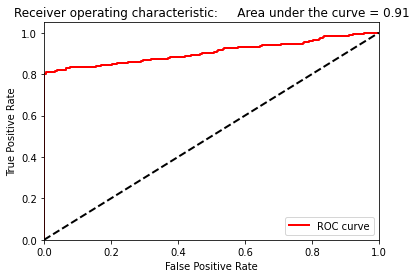

In [18]:
# 연산을 통해 원본 차원으로 재생성
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA). \
    dot(sparsePCA.components_) + np.array(X_train.mean(axis=0))
X_train_sparsePCA_inverse = \
    pd.DataFrame(data=X_train_sparsePCA_inverse, index=X_train.index)

anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

In [19]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.75
Recall:  0.79
Fraud Caught out of 330 Cases: 261


희소 PCA를 이용하여 이상치 탐지 모델을 만들 결과, 평균 정밀도가 0.75이고 사기 거래의 80% 탐지가 가능한 것을 알 수 있습니다.

### 4.커널 PCA를 활용한 이상치 탐지

커널 PCA는 비선형 계열의 PCA로, 사기 거래가 정상 거래와 선형으로 구분되지 않는 경우에 유용합니다.  
먼저, 생성하고자 하는 주성분의 개수, 커널를 지정해야 합니다.  
또한, 사이킷런에서 제공하는 내장 함수인 inverse_transform 함수를 적용하기 위해 fit_inverse_transform의 값을 true로 설정해야 합니다.  
마지막으로, 커널 PCA는 수행 시간이 오래 걸리기 때문에 데이터 셋의 처음 2천개 샘플만 가지고 훈련을 진행하였습니다. 
전체 train 데이터 셋을 변환하고 주성분을 생성합니다. 그런 다음 inverse_transform 함수로 커널 PCA에서 파생된 주성분으로부터 원본 차원을 재생성합니다.

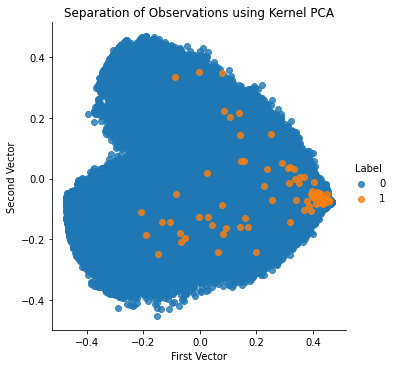

In [20]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 27
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train.iloc[:2000])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

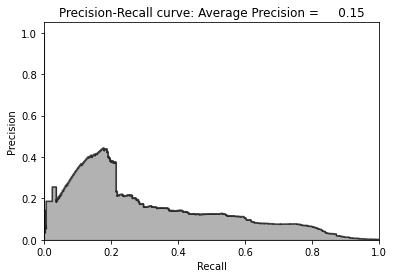

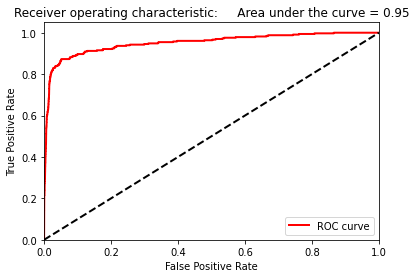

In [21]:
# View plot
anomalyScoresKernelPCA = anomalyScores(X_train, X_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoresKernelPCA, True)

In [22]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.22
Recall:  0.23
Fraud Caught out of 330 Cases: 77


위의 결과를 확인해보면 평균 정밀도가 0.21로 사용 불가한 사기 탐지 솔루션인 것을 알 수 있습니다.

커널 PCA는 일반 PCA와 희소 PCA의 결과보다 훨씬 나쁜 것을 확인할 수 있습니다.  

이전 모델이 성능이 더 잘나오므로 신용카드사기 탐지에는 커널 PCA 모델은 부적합하다고 볼 수 있을 것 같습니다.

### 5.GRP를 활용한 이상치 탐지

마지막으로, 가우시안 랜덤 투영(GRP)을 사용한 이상 탐지 모델을 생성해보겠습니다.  
GRP 모델에서는 주성분 개수 또는 eps 파라미터를 설정할 수 있습니다.   
본 예제 에서는 주성분 개수만 설정해서 해보겠습니다.  
GRP 모델은 속도가 매우 빠르다는 장점을 가지고 있으며 희소 PCA와 마찬가지로, 사이킷런에서 제공하는 함수가 없기 때문에 inverse_transform 함수를 직접 구현해야 합니다.

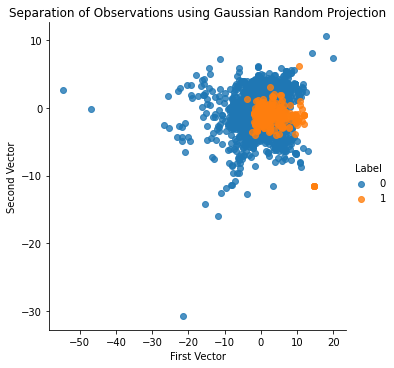

In [23]:
# Gaussian Random Projection
from sklearn.random_projection import GaussianRandomProjection

n_components = 27
eps = None
random_state = 2018

GRP = GaussianRandomProjection(n_components=n_components, \
                               eps=eps, random_state=random_state)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X_train.index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

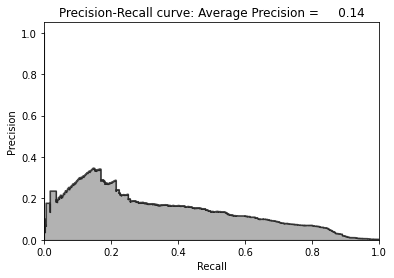

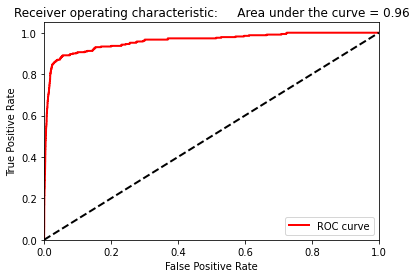

In [24]:
# View plot
X_train_GRP_inverse = np.array(X_train_GRP).dot(GRP.components_)
X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse, \
                                   index=X_train.index)

anomalyScoresGRP = anomalyScores(X_train, X_train_GRP_inverse)
preds = plotResults(y_train, anomalyScoresGRP, True)

In [25]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.22
Recall:  0.23
Fraud Caught out of 330 Cases: 76


위의 결과를 확인해보면 커널 PCA와 마찬가지로 평균 정밀도가 0.21로 사용 불가한 사기 탐지 솔루션인 것을 알 수 있습니다.
이 모델 또한 신용카드 사기 탐지 데이터에는 결과가 좋지 않으므로 사용하지 않는 것이 좋을 것 같습니다.

### **결론**

지금까지 다양한 비지도 머신러닝 기반의 이상 탐지 기법들을 활용하여 사기 거래 탐지 모델을 만들어보고 결과를 비교해보았습니다.

동일한 기법이라도 주성분의 수에 따라 결과가 달랐기 때문에 최적의 주성분 개수를 찾는 과정이 중요하다는 것을 알 수 있었습니다.

또한, 데이터에 적합한 이상치 탐지 기법을 찾는 것의 중요성을 알 수 있었습니다. 신용카드 데이터의 경우, 27개의 주성분을 이용하여 일반 PCA나 희소 PCA 기법을 이용하는 경우의 성능이 가장 좋았습니다.

다음 포스팅에는 오늘 소개한 방법 외의 추가적인 '비지도 머신러닝 기반의 이상 탐지' 편으로 찾아뵙겠습니다.

😊감사합니다😊